## background 
- 32% survival
- women,children,upper class more likely survived
- not enough boats

## load utils

In [1]:
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from util import *
from onehot import LabelBinarizerEx
from pipeline import FeaturePipeline, DataFramePipeline
from binning import Binner
from title import TitleExtractor
from cabin import HasCabin
from ensemble import EnsembleStackClassifierEx
from addcols import AddColumns
from impute import GroupImputer
from alone import IsAlone

C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load train data

In [2]:
import pandas as pd
passenger_train=pd.read_csv('train.csv')
target_col='Survived'
id_col='PassengerId'
target=passenger_train[target_col]
total_num=len(passenger_train)

## explore the data

In [3]:
passengers=passenger_train.copy()
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# passenger_train.info()

### describe number features

In [5]:
# passenger_train.describe()

### describe category features

In [6]:
# passenger_train.describe(include=['O'])

### correlations

In [7]:
# passenger_train.corr()

### pivot features

In [8]:
passengers[['Pclass','Survived']].groupby('Pclass').mean().sort_values('Survived',ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


class 1 has more survivals

In [9]:
passengers[['Sex','Survived']].groupby('Sex').mean().sort_values('Survived',ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


female survived more than male

In [10]:
passengers[['SibSp','Survived']].groupby('SibSp').mean().sort_values('Survived',ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


it seems with one or two sps has more survivals

In [11]:
passengers[['Parch','Survived']].groupby('Parch').mean().sort_values('Survived',ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


In [12]:
passenger_train[['Embarked','Survived']].groupby('Embarked').mean().sort_values('Survived',ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


## feature engineering

### extract title from name

In [13]:
# passenger_train2=passenger_train.copy()
# passenger_train2['Title'] = passenger_train2['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# pd.crosstab(passenger_train2['Title'], passenger_train2['Sex'])

### family size

In [14]:
passengers['FamilySize']=passengers['SibSp']+passengers['Parch']
passengers[['FamilySize','Survived']].groupby('FamilySize').mean().sort_values('Survived',ascending=False)

,Survived
FamilySize,
3,0.724138
2,0.578431
1,0.552795
6,0.333333
0,0.303538
4,0.200000
5,0.136364
7,0.000000
10,0.000000


In [15]:
b=Binner(strategy=[4])
passengers['BigFamily']=b.transform(passengers[['FamilySize']].values)
passengers[['BigFamily','Survived']].groupby('BigFamily').mean().sort_values('Survived',ascending=False)

,Survived
BigFamily,
0,0.400483
1,0.161290


is alone

In [16]:
b=Binner(strategy=[1])
passengers['IsAlone']=1-b.transform(passengers[['FamilySize']].values)
passengers[['IsAlone','Survived']].groupby('IsAlone').mean().sort_values('Survived',ascending=False)

,Survived
IsAlone,
0,0.505650
1,0.303538


### binning age and fare

In [17]:
# ages=passenger_train['Age'].quantile(np.linspace(0.1,1,7))
# ages

In [18]:
# fares=passenger_train['Fare'].quantile(np.linspace(0.1,1,5))
# fares

In [19]:
b=Binner([14.,35.,50.])
passengers['Age']=b.transform(passengers[['Age']].values)

In [20]:
passengers[['Age','Survived']].groupby('Age').mean().sort_values('Survived',ascending=False)

,Survived
Age,
0,0.591549
2,0.416149
1,0.377451
3,0.314741


In [21]:
b=Binner([8.,14.,31.,66.])
passengers['Fare']=b.transform(passengers[['Fare']].values)
passengers[['Fare','Survived']].groupby('Fare').mean().sort_values('Survived',ascending=False)

,Survived
Fare,
4,0.681034
3,0.477064
2,0.434783
1,0.302564
0,0.215768


### visualize

In [22]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sns
# g = sns.FacetGrid(passenger_train, col='Survived')
# g.map(plt.hist, 'Age', bins=20)
# plt.show()

In [23]:
# g = sns.FacetGrid(passenger_train, col='Survived')
# g.map(plt.hist, 'Pclass', bins=20)
# plt.show()

In [24]:
s=StandardScaler()
s.fit_transform([0,1,2,3,4,6])

C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([-1.35224681, -0.84515425, -0.3380617 ,  0.16903085,  0.6761234 ,
        1.69030851])

### feature pipelines

In [25]:
passenger_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [26]:
full_pipeline=DataFramePipeline([
    FeaturePipeline('Pclass','Pclass',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('Name','Title',Pipeline([('title',TitleExtractor())])),
    FeaturePipeline('Title','',Pipeline([('onehot',LabelBinarizerEx(['Title']))])),
    FeaturePipeline('Sex','',Pipeline([('onehot',LabelBinarizerEx(['Sex']))])),
    FeaturePipeline(['Pclass','Sex','Age'],'Age_band',Pipeline([('impute',GroupImputer(['Pclass','Sex','Age'])),
                                                                ('binning',Binner([14.,35.,50.])),
                                                                ('scale',StandardScaler()),
                                              ])),
    FeaturePipeline(['SibSp','Parch'],'FamilySize',Pipeline([('addcols',AddColumns())])),
    FeaturePipeline('FamilySize','BigFamily',Pipeline([('binning',Binner([4]))])),
    FeaturePipeline('FamilySize','IsAlone',Pipeline([('alone',IsAlone())])),
    FeaturePipeline('SibSp','SibSp',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('Parch','Parch',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('FamilySize','FamilySize',Pipeline([('scale',StandardScaler())])),
    FeaturePipeline('Fare','Fare_band',Pipeline([('binning',Binner([8.,14.,31.,66.])),
                                                 ('scale',StandardScaler()),])),
    FeaturePipeline('Cabin','Cabin_has',Pipeline([('has',HasCabin())])),
    FeaturePipeline('Embarked','',Pipeline([('onehot',LabelBinarizerEx(['Embarked']))])),
])

prepared_passenger_train=full_pipeline.fit_transform(passenger_train)
prepared_passenger_train.head()

C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\apps\Anaconda2\envs\handson\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_male,Age_band,FamilySize,BigFamily,IsAlone,Fare_band,Cabin_has,Embarked_C,Embarked_Q,Embarked_S
0,1,0,1.0,"Braund, Mr. Owen Harris",male,22.0,0.125,0.0,A/5 21171,7.2500,...,1,0.333333,0.1,0,0,0.00,0,0,0,1
1,2,1,0.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,0.125,0.0,PC 17599,71.2833,...,0,0.666667,0.1,0,0,1.00,1,1,0,0
2,3,1,1.0,"Heikkinen, Miss. Laina",female,26.0,0.000,0.0,STON/O2. 3101282,7.9250,...,0,0.333333,0.0,0,1,0.00,0,0,0,1
3,4,1,0.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,0.125,0.0,113803,53.1000,...,0,0.666667,0.1,0,0,0.75,1,0,0,1
4,5,0,1.0,"Allen, Mr. William Henry",male,35.0,0.000,0.0,373450,8.0500,...,1,0.666667,0.0,0,1,0.25,0,0,0,1


In [27]:
np.abs(prepared_passenger_train.corr()['Survived']).sort_values(ascending=False)

Survived            1.000000
Title_Mr            0.549199
Sex_male            0.543351
Sex_female          0.543351
Title_Mrs           0.339040
Pclass              0.338481
Title_Miss          0.327093
Cabin_has           0.316912
Fare_band           0.302552
Fare                0.257307
IsAlone             0.203367
Embarked_C          0.168240
Embarked_S          0.155660
BigFamily           0.125147
Title_Master        0.085221
Parch               0.081629
Age                 0.077221
SibSp               0.035322
Age_band            0.031114
Title_RareOrNone    0.022030
FamilySize          0.016639
PassengerId         0.005007
Embarked_Q          0.003650
Name: Survived, dtype: float64

In [28]:
train_data=prepared_passenger_train.drop(['Survived','PassengerId','Fare','Name','Ticket','Cabin','Embarked','Title','Sex','Age'],axis=1)
train_data.describe()

,Pclass,SibSp,Parch,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_RareOrNone,Sex_female,Sex_male,Age_band,FamilySize,BigFamily,IsAlone,Fare_band,Cabin_has,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.065376,0.063599,0.044893,0.204265,0.580247,0.140292,0.030303,0.352413,0.647587,0.433595,0.090460,0.069585,0.602694,0.405724,0.228956,0.188552,0.086420,0.722783
std,0.418036,0.137843,0.134343,0.207186,0.403390,0.493796,0.347485,0.171516,0.477990,0.477990,0.244129,0.161346,0.254589,0.489615,0.335755,0.420397,0.391372,0.281141,0.447876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.125000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.666667,0.100000,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## train

In [29]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

base_clfs=[
#       LogisticRegression(n_jobs=-1),
      SVC(probability=False),
#       RandomForestClassifier(n_jobs=-1),
#       GradientBoostingClassifier(),
#       AdaBoostClassifier(), 
#       ExtraTreesClassifier(n_jobs=-1), 
#       XGBClassifier()
]

In [30]:
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

def trainModels(train_data, target):
    scores=[cross_val_score(clf,train_data,target,scoring='accuracy',cv=5,n_jobs=-1,verbose=1).mean() for clf in base_clfs]

    labels=[c.__class__.__name__[:3] for c in base_clfs]
    X=np.arange(len(base_clfs))
    bar(X,scores,tick_label=labels,color='rgb')
    ylim(0.5,1.0)
    show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


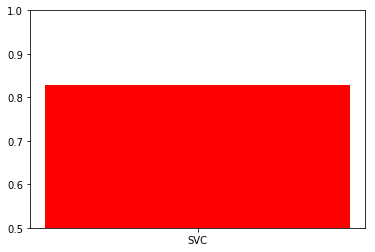

[('SVC', 0.82830146390489789)]


In [31]:
trainModels(train_data,target)

### drop some features

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


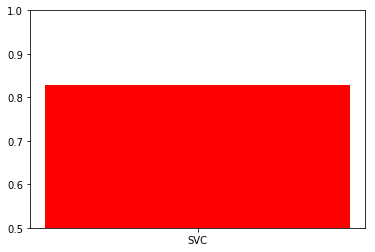

[('SVC', 0.82941878234065203)]


In [32]:
train_data2=train_data.drop(['Embarked_Q','FamilySize','Title_RareOrNone','Age_band','SibSp','Parch'],axis=1)
trainModels(train_data2,target)

## tuning

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid_set=[
#                 {'C':[0.01,0.1,0.5,1.]},
                {'C':[1.,10.,],'kernel':['rbf','poly'],'gamma':[0.001,0.01,0.1,1.],'coef0':[1.,10.,100.]},
#                 {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300],'max_depth':[3,5,8]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300]},
#                 {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300],'max_depth':[5,10,15],'gamma':[0.01,0.1,0.5]},
               ]

def tuneModels(train_data,target):
    results=[]
    for i in range(len(base_clfs)):
        gs=GridSearchCV(estimator=base_clfs[i],param_grid=param_grid_set[i],scoring='accuracy',n_jobs=-1,verbose=1,cv=5)
        gs.fit(train_data,target)
        results.append((gs.best_estimator_,gs.best_score_))
    print(sorted(results,key=lambda x:x[1],reverse=True))


In [34]:
# tuneModels(train_data,target)

In [35]:
# tuneModels(train_data2,target)

## emsembling

### voting

In [36]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.model_selection import cross_val_score

# voter=VotingClassifier(estimators=[(c.__class__.__name__, c) for c in clfs], voting='soft',n_jobs=-1)
# scores=cross_val_score(voter,prepared_passenger_train,target,cv=10,n_jobs=-1,scoring='accuracy')
# scores.mean()

### stacking

In [37]:
# from brew.base import Ensemble
# from brew.stacking import EnsembleStackClassifier,EnsembleStack
# import sklearn

# layer_1 = Ensemble(clfs)
# layer_2 = Ensemble([sklearn.clone(clfs[0])])

# stack = EnsembleStack(cv=len(clfs))

# stack.add_layer(layer_1)
# stack.add_layer(layer_2)

# sclf = EnsembleStackClassifierEx(stack)
# from sklearn.model_selection import train_test_split
# # X_train,y_train,X_test,y_test=train_test_split(prepared_passenger_train.values,target,test_size=0.3,random_state=0)
# # print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
# sclf.fit(prepared_passenger_train.values[:600],target[:600])
# sclf.score(prepared_passenger_train.values[600:],target[600:])
# scores=cross_val_score(sclf,prepared_passenger_train.values,target,cv=5,n_jobs=-1)
# scores.mean()

# sclf.fit(prepared_passenger_train.values[:600],target[:600])

## test it

In [38]:
# passenger_test=pd.read_csv('test.csv')
# test_id=passenger_test[id_col]
# cols=drop_cols.copy()
# cols.remove(target_col)
# passenger_test.drop(cols,axis=1,inplace=True)

In [39]:
# prepared_passenger_test=full_pipeline.transform(passenger_test)
# prepared_passenger_test.head()

In [40]:
# clf=gs[0].best_estimator_
# # clf.fit(prepared_passenger_train,target)
# survived=clf.predict(prepared_passenger_test.values)
# test_Survived = pd.Series(survived, name="Survived")
# results = pd.concat([test_id,test_Survived],axis=1)
# results.to_csv("result.csv",index=False)

In [41]:
# help(AdaBoostClassifier)